In [1]:
#default_exp haystack_code_search

In [2]:
#export
import pprint
import numpy as np
import pandas as pd
import requests
import torch

from haystack import Finder
from haystack.database.elasticsearch import ElasticsearchDocumentStore
from haystack.database.memory import InMemoryDocumentStore

from haystack.retriever.dense import EmbeddingRetriever
from haystack.utils import print_answers
from pytorch_hackathon import zero_shot_learning

In [3]:
%cd ..

/home/kuba/Projects/pytorch_hackathon


In [4]:
!ls data

feeds.txt  topics.txt  zsl_feed_results.csv


In [5]:
rss_feed_urls = list(pd.read_table('data/feeds.txt', header=None).iloc[:,0].values)

In [6]:
feed_df = zero_shot_learning.get_feed_df(rss_feed_urls)

100%|██████████| 16/16 [00:08<00:00,  1.88it/s]
/home/kuba/Projects/pytorch_hackathon/pytorch_hackathon/zero_shot_learning.py:69: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 69 of the file /home/kuba/Projects/pytorch_hackathon/pytorch_hackathon/zero_shot_learning.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  feed_df['text'] = feed_df['summary'].apply(lambda s: bs4.BeautifulSoup(s).text)


In [7]:
#export

use_gpu = torch.cuda.is_available()

In [8]:
pretty_print = pprint.PrettyPrinter(indent=2).pprint

In [9]:
feed_df.head()

,title,title_detail,links,link,summary,summary_detail,id,guidislink,tags,text,...,published_parsed,comments,authors,author,author_detail,updated,updated_parsed,content,href,media_thumbnail
0,I2L-MeshNet: Image-to-Lixel Prediction Network for Accurate 3D Human Pose an...,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds....","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.c...",https://paperswithcode.com/paper/i2l-meshnet-image-to-lixel-prediction-network,Most of the previous image-based 3D human pose and mesh estimation methods e...,"{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.c...",https://paperswithcode.com/paper/i2l-meshnet-image-to-lixel-prediction-network,False,"[{'term': '3d hand pose estimation', 'scheme': None, 'label': None}, {'term'...",Most of the previous image-based 3D human pose and mesh estimation methods e...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Polysemy Deciphering Network for Robust Human-Object Interaction Detection,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds....","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.c...",https://paperswithcode.com/paper/polysemy-deciphering-network-for-robust-human,"To address this issue, in this paper, we propose a novel Polysemy Decipherin...","{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.c...",https://paperswithcode.com/paper/polysemy-deciphering-network-for-robust-human,False,"[{'term': 'Human-object interaction detection', 'scheme': None, 'label': Non...","To address this issue, in this paper, we propose a novel Polysemy Decipherin...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cascade Graph Neural Networks for RGB-D Salient Object Detection,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds....","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.c...",https://paperswithcode.com/paper/cascade-graph-neural-networks-for-rgb-d,Current works either simply distill prior knowledge from the corresponding d...,"{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.c...",https://paperswithcode.com/paper/cascade-graph-neural-networks-for-rgb-d,False,"[{'term': 'Salient object detection', 'scheme': None, 'label': None}]",Current works either simply distill prior knowledge from the corresponding d...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Convolutional Complex Knowledge Graph Embeddings,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds....","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.c...",https://paperswithcode.com/paper/convolutional-complex-knowledge-graph,"In this paper, we study the problem of learning continuous vector representa...","{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.c...",https://paperswithcode.com/paper/convolutional-complex-knowledge-graph,False,"[{'term': 'Knowledge graph embeddings', 'scheme': None, 'label': None}, {'te...","In this paper, we study the problem of learning continuous vector representa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Quantum State Tomography with Conditional Generative Adversarial Networks,"{'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds....","[{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.c...",https://paperswithcode.com/paper/quantum-state-tomography-with-conditional,We augment a CGAN with custom neural-network layers that enable conversion o...,"{'type': 'text/html', 'language': None, 'base': 'https://us-east1-ml-feeds.c...",https://paperswithcode.com/paper/quantum-state-tomography-with-conditional,False,"[{'term': 'Quantum state tomography', 'scheme': None, 'label': None}]",We augment a CGAN with custom neural-network layers that enable conversion o...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#export

document_store = InMemoryDocumentStore(
    embedding_field="article_emb",
)

In [11]:
#export


model_name = "sentence-transformers/bert-base-nli-mean-tokens"


retriever = EmbeddingRetriever(
    document_store=document_store,
    embedding_model=model_name,
    use_gpu=use_gpu)

08/12/2020 16:08:36 - INFO - haystack.retriever.dense -   Init retriever using embeddings of model sentence-transformers/bert-base-nli-mean-tokens
08/12/2020 16:08:36 - INFO - farm.utils -   device: cuda n_gpu: 1, distributed training: False, automatic mixed precision training: None
08/12/2020 16:08:36 - INFO - farm.infer -   Could not find `sentence-transformers/bert-base-nli-mean-tokens` locally. Try to download from model hub ...
08/12/2020 16:08:38 - WARNING - farm.modeling.language_model -   Could not automatically detect from language model name what language it is. 
	 We guess it's an *ENGLISH* model ... 
	 If not: Init the language model by supplying the 'language' param.
08/12/2020 16:08:44 - INFO - farm.utils -   device: cuda n_gpu: 1, distributed training: False, automatic mixed precision training: None


In [12]:
feed_df.columns

Index(['title', 'title_detail', 'links', 'link', 'summary', 'summary_detail',
       'id', 'guidislink', 'tags', 'text', 'feed', 'published',
       'published_parsed', 'comments', 'authors', 'author', 'author_detail',
       'updated', 'updated_parsed', 'content', 'href', 'media_thumbnail'],
      dtype='object')

In [13]:
#export

article_texts = feed_df['text']

In [14]:
#export

article_embeddings = retriever.embed_queries(texts=list(article_texts))

Inferencing Samples: 100%|██████████| 74/74 [00:10<00:00,  7.34 Batches/s]


In [15]:
#export

feed_df['article_emb'] = article_embeddings 

In [18]:
#export

document_store.write_documents(feed_df.to_dict(orient='records'))

In [23]:
feed_df.iloc[1]['text']

'To address this issue, in this paper, we propose a novel Polysemy Deciphering Network (PD-Net) that decodes the visual polysemy of verbs for HOI detection in three distinct ways. Code: https://github.com/MuchHair/PD-Net'

In [24]:
retriever.retrieve(
    feed_df.iloc[1]['text']
)[1]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 15.21 Batches/s]


Document(id='898ca6bee19ea3e27a3f72e5e59f59b7', text='In this paper, we study the problem of learning continuous vector representations of knowledge graphs for predicting missing links. Code: https://github.com/conex-kge/ConEx', external_source_id=None, question=None, query_score=0.798127055398364, meta={'title': 'Convolutional Complex Knowledge Graph Embeddings', 'title_detail': {'type': 'text/plain', 'language': None, 'base': 'https://us-east1-ml-feeds.cloudfunctions.net/pwc/latest', 'value': 'Convolutional Complex Knowledge Graph Embeddings'}, 'links': [{'rel': 'alternate', 'type': 'text/html', 'href': 'https://paperswithcode.com/paper/convolutional-complex-knowledge-graph'}], 'link': 'https://paperswithcode.com/paper/convolutional-complex-knowledge-graph', 'summary': 'In this paper, we study the problem of learning continuous vector representations of knowledge graphs for predicting missing links. <p>Code: <a href="https://github.com/conex-kge/ConEx">https://github.com/conex-kge/Co

In [26]:
text_vecs = np.array(retriever.embed_queries(list(feed_df['text'].iloc[:100])))

Inferencing Samples: 100%|██████████| 25/25 [00:03<00:00,  7.27 Batches/s]


In [29]:
example_vec = np.array(feed_df.iloc[0]['article_emb'])

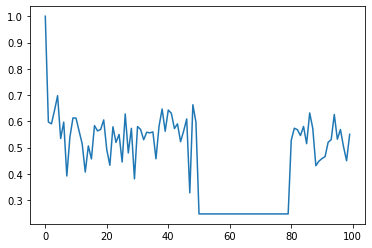

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.plot(metrics.pairwise.cosine_similarity([example_vec], text_vecs)[0])